# Multilinear PCA

This short notebook walks through a basic implementation of **Multilinear Principal Component Analysis** [1,3], using the **TensorLy** [2] library for Python, demonstrating the computation of the projection matrices using *Alternating Partial Projections*.

Included is the following:

1. [MPCA at a high-level](#MPCA-at-a-high-level)
2. [Forming the image tensors](#Forming-the-image-tensors)
3. [Computing the mean tensor](#Computing-the-mean-tensor)
4. [Initialising the projection matrices](#Initialising-the-projection-matrices)
5. [Computing the partial multilinear projection](#Computing-the-partial-multilinear-projection)
6. [Computing the mode-$n$ total scatter matrix](#Computing-the-mode-$n$-total-scatter-matrix)
7. [Solving for projection matrix $\mathbf{U}^{(n)}$](#Solving-for-projection-matrix-$\mathbf{U}^{(n)}$)
8. [Putting it all together in k-step optimization](#Putting-it-all-together-in-k-step-optimization)

---

[1]: H. Lu, K. N. Plataniotis and A. N. Venetsanopoulos, "MPCA: Multilinear Principal Component Analysis of Tensor Objects," in IEEE Transactions on Neural Networks, vol. 19, no. 1, pp. 18-39, Jan. 2008, doi: 10.1109/TNN.2007.901277.

[2]: Jean Kossaifi, Yannis Panagakis, Anima Anandkumar and Maja Pantic, TensorLy: Tensor Learning in Python, https://arxiv.org/abs/1610.09555.

[3]: Multilinear Subspace Learning: Dimensionality Reduction of Multidimensional Data, Haiping Lu, K. N. Plataniotis, and A. N. Venetsanopoulos, Chapman & Hall/CRC Press Machine Learning and Pattern Recognition Series, Taylor and Francis, ISBN: 978-1-4398572-4-3, December 2013.

## MPCA at a high-level

In a similar manner to regular PCA, *Multilinear PCA* (MPCA) seeks a projection onto a (tensor) subspace where the total scatter is maximised [1]. In contrast to PCA, MPCA seeks not a single projection matrix, but $k$ projection matrices $\mathbf{U}^{(k)}$ for each mode $k$ of a higher-order tensor, $\mathcal{X}\in\mathbb{R}^{I_1\times I_2\times\cdots\times I_{N}}$.

This total scatter objective is defined for the projection matrices as

$$J(\mathbf{U}^{(k)}) = \underset{\mathbf{U}^{(k)}}{\arg\max}
\sum_{m=1}^M || \tilde{\mathcal{X}}_m \prod_{n=1}^N \times_n {\mathbf{U}^{(n)}}^\top ||^2_F,$$

where $\tilde{\mathcal{X}}_m$ is the $m$th data point with the sample mean $\bar{\mathcal{X}} = \frac{1}{M} \sum_{m=1}^{M}\mathcal{X}_m$ subtracted.

There are a few notable differences to the other algorithms presented in the notebooks. Firstly, unlike multilinear discriminant analysis, in MPCA we do not need to know the class labels of the datapoints. MPCA maximises the total scatter without regard for class label. Secondly, whilst sharing some similarities with Tensorfaces, we don't require any such "supervision-by-data-structure" from MPCA, as we do with tensorfaces.

In [1]:
from matplotlib import pyplot as plt

import tensorly as tl
import numpy as np

tl.set_backend('numpy')
np.random.seed(1234)

## Forming the image tensors

Let's first load in the image dataset $\mathcal{X}\in\mathbb{R}^{M\times H\times W}$. To form this 3rd-order tensor, we'll use a helper function to download the **YaleB** dataset (note: this cell will take a few minutes to run if your internet connection is slow).

In our case, each image sample tensor is 2nd order, but precisely the same approach applies to higher-order tensors (e.g. image tensors of 3rd-order, with a 'colour' channel).

Note that we consider the first mode to be the "sample" mode: that is, we have $M=1931$ lots of second-order tensors $\mathcal{X}_m\in\mathbb{R}^{H \times W}$.

In [2]:
from utils import fetch_cropped_yaleb

dataset_path = './data/'
yaleb_data = fetch_cropped_yaleb(dataset_path, zooming=0.5, max_n_subjects=None)

X = [yaleb_data[x]['images'] for x in yaleb_data.keys()]
y = [[i] * len(x) for i, x in enumerate(X)]

# store the indices of training data that belong to each identity
people_idx = [[] for _ in range(len(y))]

X = np.concatenate(np.array(X))
y = np.concatenate(np.array(y))

# get test and train splits
num_data = len(X)
num_train = round(num_data * 0.8)

idx = np.random.permutation(num_data)
tr_idx, te_idx = idx[:num_train], idx[num_train:]

X_train_raw, X_test_raw = X[tr_idx], X[te_idx]
y_train, y_test = y[tr_idx], y[te_idx]

for i, identity in enumerate(y_train):
    # store the person's id label
    people_idx[identity] += [i]
    
X_train_raw, X_test_raw = tl.tensor(X_train_raw), tl.tensor(X_test_raw)
y_train, y_test = tl.tensor(y_train), tl.tensor(y_test)
    
print('---')
print('Shape of training set is: {}'.format(X_train_raw.shape))
print('Shape of test set is: {}'.format(X_test_raw.shape))

---
Shape of training set is: (1931, 96, 84)
Shape of test set is: (483, 96, 84)


/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/home/james/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  del sys.path[0]


## Computing the mean tensor

Like with regular PCA, we first need to center each data point

$$\tilde{\mathcal{X}}_m = \mathcal{X}_m - \bar{\mathcal{X}},$$

with the mean tensor $\bar{\mathcal{X}} = \frac{1}{M} \sum_{m=1}^{M}\mathcal{X}_m$. Let's do this in **TensorLy**:

In [3]:
mean_tensor = tl.mean(X_train_raw, axis=0)
X_train = X_train_raw - mean_tensor
X_test = X_test_raw - mean_tensor

and then view a few of the slices of the mean tensor:

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

def show_images(images, rows, cols, img_size, figsize=(5,5), titles=None):
    fig, axs = plt.subplots(1, 1, figsize=figsize)
    axs.axis(False)
    grid = ImageGrid(fig, 111, nrows_ncols=(rows, cols), axes_pad=0.3)

    for i, (ax, im) in enumerate(zip(grid, images)):
        ax.imshow(tl.reshape(im, img_size), cmap='gray')
        ax.axis(False)
        
        if titles is not None:
            ax.set_title(titles[i])

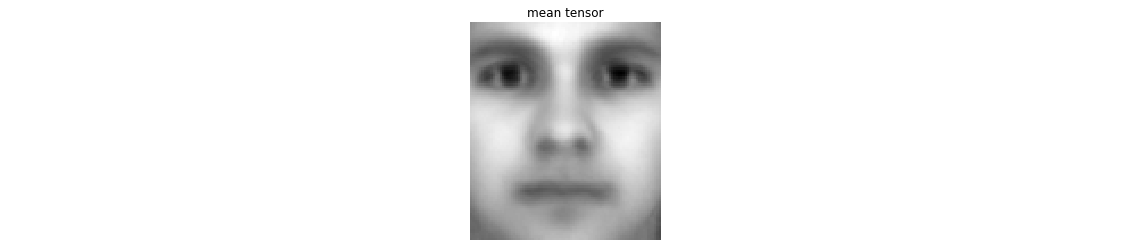

In [5]:
show_images([mean_tensor], 1, 1, (X_train[0].shape[0], X_train[1].shape[1]), figsize=(20, 4), titles=['mean tensor'])

## Initialising the projection matrices

We now need to initialize the projection matrices. We will do this again as 1-matrices for ease (but note there are much better ways to initialize these matrices, such as via *full projection truncation* [1])

In [19]:
rank = 8
factors = [tl.ones((dim, rank)) for i, dim in enumerate(list(X_train.shape)[1:])]

## Computing the partial multilinear projection 

Similarly to with the notebook on MDA, we need to project each data sample along *all modes but n*. This is due to the fact that the solution for each mode's projection matrix depends on the solutions to the other modes' matrices (For a discussion of this, see Section 5.1 in [3]).

We can do this with **TensorLy**'s `tl.tenalg.multi_mode_dot` function, by supplying the `skip=n` argument.

Such a projection of datapoint $m$ along all modes but $n$ is computed as

$$
\mathcal{Y}^{(n)}_m = \mathcal{X}_m
\times_1 {\mathbf{U}^{(1)}}^\top
\cdots
\times_{n-1} {\mathbf{U}^{(n-1)}}^\top
\times_{n+1} {\mathbf{U}^{(n+1)}}^\top
\cdots
\times_{N} {\mathbf{U}^{(N)}}^\top.
$$

As a concrete example, let's project the first datapoint $\mathcal{X}_0$ along all modes but the first (i.e. for $n=0$):

In [7]:
proj_but_k = tl.tenalg.multi_mode_dot(X[0], factors, transpose=True, skip=0)

## Computing the mode-$n$ total scatter matrix

We next need to compute the mode-$n$ **total scatter matrix** for the partial projections of $\mathcal{X}_m$ along all modes but $n$. The authors in [3] define this as

$$
\mathbf{S}^{(n)}_{T_{\hat{\mathcal{Y}}}} =
    \sum_{m=1}^{M}
        \left( {\mathbf{\hat Y}_m}_{[n]} - {\mathbf{\bar {\hat Y}}}_{[n]} \right)
        \left( {\mathbf{\hat Y}_m}_{[n]} - {\mathbf{\bar {\hat Y}}}_{[n]} \right)^\top,
$$

where $\bar{\hat{\mathbf{Y}}}_{[n]}$ is the mode-$n$ unfolding of the projection of the mean tensor $\bar{\mathcal{X}}$ along all modes but $n$. Note that we've already made the data zero-mean. Let's do this in TensorLy:

In [8]:
# ---------
# Compute the mode-k total scatter matrix
# ---------

def compute_modek_total_scatter(mode, factors):
    scatter = 0
    
    for m in range(len(X)):
        proj_but_k = tl.unfold(tl.tenalg.multi_mode_dot(X[m], factors, transpose=True, skip=mode), mode)
        scatter += tl.dot(proj_but_k, proj_but_k.T)
        
    return scatter

scatter = compute_modek_total_scatter(0, factors)

## Solving for projection matrix $\mathbf{U}^{(n)}$

Similarly to with multilinear discriminant analysis, we assume we have known the projection matrices $\mathbf{U}^{(k)}$, for $k=1,\dots,n-1,n+1,\dots,N$. We can then solve for projection matrix $\mathbf{U}^{(n)}$ by setting it equal to the $I_n^*$ many top eigenvectors of the mode-n scatter matrix computed above:

In [9]:
# solve for projection matrix for mode k as top `rank` # of eigenvectors
U, _, _ = tl.partial_svd(scatter, n_eigenvecs=rank)
factors[0] = U

# Putting it all together in k-step optimization

Let's run this process for a fixed number of iterations, performing the *Alternating Partial Projections* [3]. For each iteration, we loop over the number of modes and solve for each projection matrix $\mathbf{U}^{(k)}$ individually:


### classification using the low-dimensional tensors


To test how well our low-dimensional embeddings retain identity-discriminative information at each iteration, we employ a simple 1-NN classification approach to classify the test set. For a new test data point $\hat{\mathcal{X}}$, we first project it onto the lower dimensional subspaces as $\hat{\mathcal{Z}} = \hat{\mathcal{X}} \times_1 {\mathbf{U}^{(1)}}^\top \cdots \times_{N} {\mathbf{U}^{(N)}}^\top$, and then classify it using the simple nearest neighbour approach

$$c_i =\arg\min_i ||\mathcal{Z}_i - \hat{\mathcal{Z}} ||$$

in **TensorLy**, this can be achieved using the `tl.tenalg.multi_mode_dot` method along `modes=[1, 2]`  using the learnt mode projection matrices at time step-$t$, and `tl.norm` to measure the distance between points in the tensor subspace:

In [10]:
def one_NN(Z_train, Z_test, y_train, y_test):
    y_preds = []
    for z_test in Z_test:
        smallest_dist = np.infty
        prediction = -1

        for z, label in zip(Z_train, y_train):
            dist = tl.norm(z - z_test).item()
            if dist < smallest_dist:
                smallest_dist = dist
                prediction = label.item()

        y_preds += [int(prediction)]

    acc = (y_preds==tl.to_numpy(y_test)).mean()
    return acc


def compute_accuracy(X_train, X_test, y_train, y_test, factors):
    Z_train = tl.tenalg.multi_mode_dot(X_train, factors, modes=[1, 2], transpose=True)
    Z_test = tl.tenalg.multi_mode_dot(X_test, factors, modes=[1, 2], transpose=True)
    return  one_NN(Z_train, Z_test, y_train, y_test)

In [15]:
total_iters = 5

# dimension of desired low-dim subspace (shared across all modes)
rank = 64
num_modes = len(X.shape) - 1

accs = []
its = []

# initialise the factor matrices
factors = [tl.ones((dim, rank)) for i, dim in enumerate(list(X_train.shape)[1:])]

accs += [compute_accuracy(X_train, X_test, y_train, y_test, factors)]
its += [0]

for t in range(1, total_iters + 1):
    for k in range(num_modes):
        scatter = compute_modek_total_scatter(k, factors)
        
        U, _, _ = tl.partial_svd(scatter, n_eigenvecs=rank)
        factors[k] = U
        
    accs += [compute_accuracy(X_train, X_test, y_train, y_test, factors)]
    its += [t]
            
print('...done')
print('best accuracy of {} at iteration {}: '.format(np.max(np.array(accs)), its[np.argmax(np.array(accs))] ))

...done
best accuracy of 0.7494824016563147 at iteration 1: 


## classification accuracy vs PCA

Let's also run the identity classification on the embeddings attained via PCA (with the same number of components) on the vectorized pixels and see how MPCA compares:

In [17]:
from sklearn.decomposition import PCA

clf = PCA(n_components=rank)

img_shape = [-1, X_train.shape[1] * X_train.shape[2]]
clf.fit(X_train.reshape(img_shape))

Z_train = clf.transform(X_train.reshape(img_shape))
Z_test = clf.transform(X_test.reshape(img_shape))

pca_acc = one_NN(tl.tensor(Z_train), tl.tensor(Z_test), y_train, y_test)
print(pca_acc)

0.6314699792960663


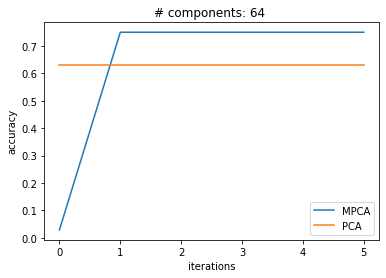

best accuracy of 0.7494824016563147 at iteration 1: 
pca:  0.6314699792960663


In [18]:
plt.plot(its, accs, label='MPCA')
plt.title('# components: {} '.format(rank))
plt.plot(its, [pca_acc] * len(its), label='PCA')
plt.xlabel('iterations')
plt.ylabel('accuracy')

plt.legend()
plt.show()

print('best accuracy of {} at iteration {}: '.format(np.max(np.array(accs)), its[np.argmax(np.array(accs))] ))
print('pca: ', pca_acc)